In [9]:
import pandas as pd
import os
import numpy   as np
import matplotlib.pyplot as plt
import glob
import json

In [10]:
def generate_average_df(algorithms, data_sets, results_path, output_path): 
    output = {}
    for algorithm in algorithms: 
        output[algorithm] = {}
        for data_set in data_sets: 
            print(algorithm, data_set)
            try:
                results = pd.read_csv(os.path.join(results_path, algorithm, data_set,'results_table.csv'), header=None)
                results = results[4].values
                output[algorithm][data_set] = str(round(np.mean(results), 3)) + " (" + str(round(np.std(results),3)) +")" 
            except: 
                output[algorithm][data_set] = "NA"
    output_df = pd.DataFrame.from_dict(output, orient="index")
    output_df.to_latex(os.path.join(output_path, 'average_f1_table.txt'))

In [3]:
def generate_histograms(algorithms, data_sets, results_path, output_path, data_path):
    output = {}
    for algorithm in algorithms: 
        output[algorithm] = {}
        for data_set in data_sets: 
            files = glob.glob(os.path.join(results_path, algorithm, data_set, '*.json'))
            if not files:
                output[algorithm][data_set] = "N/A"
                continue
            try:
                ARL = []
                for file in files: 
                    with open(file) as f:
                        result = json.load(f)
                    ts_name = result['data_name']
                    if result['score'] is None: continue
                    detected = np.array(result['cp'])[:, 0]
                    labels = pd.read_csv(os.path.join(data_path, data_set,"{}_labels.csv".format(ts_name)), header=None)
                    labels = labels.values[:,0]
                    selected = np.zeros(len(detected))
                    print(len(detected), len(selected))
                    for cp in labels:
                        dist = (detected-cp).astype(float)
                        dist[dist < 0] = np.inf
                        min_ = np.min(np.abs(dist) + selected *10000)
                        index = np.argmin(np.abs(dist) + selected *10000)
                        if min_ < 200:
                            ARL.append(dist[index])
                            selected[index] = 1
                print(algorithm, data_set, len(ARL))
#                 output[algorithm][data_set] = str(round(np.mean(np.abs(ARL)), 3)) + " (" + str(round(np.std(np.abs(ARL)), 3)) +"), " + str(round(np.median(np.abs(ARL)), 3)) 
                output[algorithm][data_set] =  str(round(np.median(np.abs(ARL)), 3))+ f'({str(len(ARL))})' 
#                 
#                 fig = plt.figure(figsize=(6,4))
#                 plt.hist(ARL, bins = 20, color = 'g', alpha=0.7)
#                 plt.title('{} ({})'.format(data_set, algorithm))
#                 fig.savefig('{}/{}_{}'.format(output_path, data_set, algorithm), dpi = 400)
            except: 
                output[algorithm][data_set] = "N/A"
    output_df = pd.DataFrame.from_dict(output)
    output_df.to_latex(os.path.join(output_path, 'arl_table.txt'))
    
 

In [164]:
def generate_arl_plots(algorithms, data_set, results_path, output_path, data_path):
    fig = plt.figure(figsize=(7,5))
    for algorithm in algorithms:         
        print(algorithm)
        files = glob.glob(os.path.join(results_path, algorithm, data_set, '*.json'))
        if not files:
            continue
        ARL = []
        for file in files: 
            with open(file) as f:
                result = json.load(f)
            ts_name = result['data_name']
            if result['score'] is None: 
                continue
            detected = np.array(result['cp'])[1:, 0]
            labels = pd.read_csv(os.path.join(data_path, data_set,"{}_labels.csv".format(ts_name)), header=None)
            labels = labels.values#[:-1, :]
            len_ts = labels[-1,-1] 
            labels = labels[1:,0]
            labels = labels[::-1]
            if not len(detected): 
                ARL = ARL + (np.ones(len(labels))*len_ts).tolist()
                continue
            for i, cp in enumerate(labels):
                dist = (detected-cp).astype(float)
                dist[dist < 0] = np.inf
                min_ = np.min(dist)
                if min_ == np.inf: 
                    ARL.append(len_ts)
                    continue  
                index = np.argmin(dist)
                detected_cp = detected[index]
                if i>0:
                    if detected_cp >= labels[i-1]: 
                        ARL.append(len_ts)
                        continue  
                ARL.append(min_)                
        plt.hist(ARL, bins = 5000, cumulative=True, label=algorithm, histtype='step', linewidth=1.5)
    plt.xlim((0,100))
    plt.title('Average Detection Delay ({} dataset)'.format(data_set))
    plt.legend(loc='upper right')
    fig.savefig('{}/{}_ARL_CDF.png'.format(output_path, data_set), dpi = 400)

        
    
 

mssa
mssa_mw
binseg
microsoft_ssa
bocpdms
klcpd


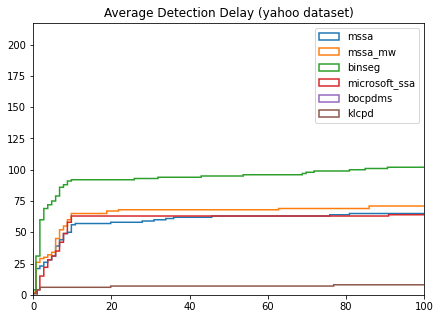

In [165]:
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data')
results_path = os.path.join(os.path.dirname(os.getcwd()), 'test')
output_path = os.path.join(os.path.dirname(os.getcwd()), 'processing')
algorithms = ['mssa','mssa_mw', 'binseg', 'microsoft_ssa', 'bocpdms', 'klcpd']
data_set = "yahoo"
generate_arl_plots(algorithms, data_set, results_path, output_path, data_path)

(array([10., 10., 10., 10., 10., 12., 12., 12., 12., 13.]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.]),
 [<matplotlib.patches.Polygon at 0x112157c50>])

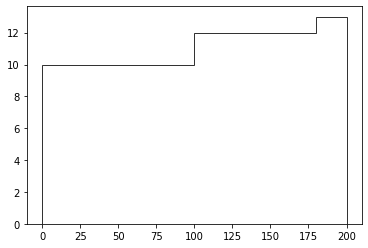

In [130]:
ARL = [1,1,1,0,0,0,0,0,0,0,100,100,200]
plt.hist(ARL, cumulative=True, label='CDF',
         histtype='step', alpha=0.8, color='k')

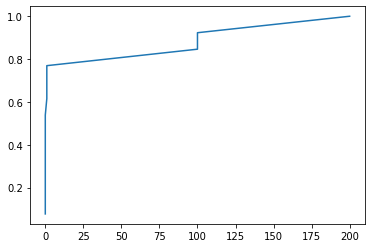

In [16]:
X=sorted(ARL)
Y=[]
l=len(X)
Y.append(float(1)/l)
for i in range(2,l+1):
    Y.append(float(1)/l+Y[i-2])
plt.plot(X,Y,label='xyz')

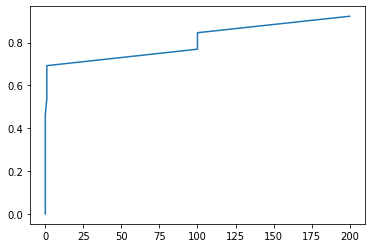

In [13]:
cdf(ARL)

In [11]:
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data')
results_path = os.path.join(os.path.dirname(os.getcwd()), 'test')
output_path = os.path.join(os.path.dirname(os.getcwd()), 'processing')
algorithms = ['mssa', 'mssa_dist', 'mssa_mw', 'mssa_mw_dist',  'binseg', 'microsoft_ssa', 'bocpdms', 'klcpd', 'no_change']
data_sets = ['struct', 'mean', 'energy', 'yahoo', 'hasc']
generate_average_df(algorithms, data_sets, results_path, output_path)
# generate_histograms(algorithms, data_sets, results_path, output_path, data_path)

mssa struct
mssa mean
mssa energy
mssa yahoo
mssa hasc
mssa_dist struct
mssa_dist mean
mssa_dist energy
mssa_dist yahoo
mssa_dist hasc
mssa_mw struct
mssa_mw mean
mssa_mw energy
mssa_mw yahoo
mssa_mw hasc
mssa_mw_dist struct
mssa_mw_dist mean
mssa_mw_dist energy
mssa_mw_dist yahoo
mssa_mw_dist hasc
binseg struct
binseg mean
binseg energy
binseg yahoo
binseg hasc
microsoft_ssa struct
microsoft_ssa mean
microsoft_ssa energy
microsoft_ssa yahoo
microsoft_ssa hasc
bocpdms struct
bocpdms mean
bocpdms energy
bocpdms yahoo
bocpdms hasc
klcpd struct
klcpd mean
klcpd energy
klcpd yahoo
klcpd hasc
no_change struct
no_change mean
no_change energy
no_change yahoo
no_change hasc


In [4]:
x = np.array([[1,2,3], [1,2,3]])

In [5]:
x.sum(axis=0)

array([2, 4, 6])